## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd

## Define Parameters

In [2]:
N = 20410 # Number of samples
Q = 150 # Initial battery capacity in AH
L = 600000 # Battery is forcibly retired after traveling L kilometers
a_min, a_max = 68, 72
b_min, b_max = -11e-8, -9e-8
c_min, c_max = -0.7, -0.55
d_min, d_max = 4.5e-6, 5.5e-6
m_mea = 3 # Standard deviation of battery individual differences
p1 = 1 # Economic value per kilometer traveled
p2 = 300 # Base price for battery recycling
deta = 0.6 # Recycling discount coefficient
z = 1000 # Minimum step length for predicting future mileage l
e_values = [0.410737377, 2.72192657, 3.231177852, 5] # Standard deviation of the battery capacity prediction algorithm errors
err_increment = 0.1 # Increment of the error standard deviation

# Simulating the battery capacity degradation process

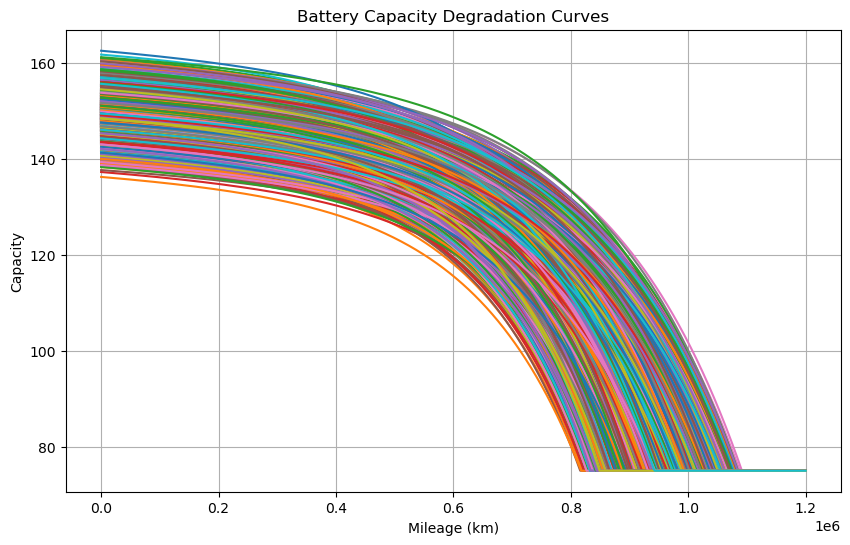

In [3]:
# Function for the change in battery capacity with mileage
def battery_capacity(l, a, b, c, d, er):
    capacity = a * np.exp(b * l) + c * np.exp(d * l) + er + Q - 70
    predicted_capacity = max(Q * 0.5, capacity)
    return predicted_capacity

# Generate samples of battery capacity degradation process and battery capacity degradation curves
def generate_samples_and_curves(N, L, z, m_mea):
    samples = []
    curves = []
    for _ in range(N):
        a = np.random.uniform(a_min, a_max)
        b = np.random.uniform(b_min, b_max)
        c = np.random.uniform(c_min, c_max)
        d = np.random.uniform(d_min, d_max)
        er = np.random.normal(0, m_mea)
        eQ = battery_capacity(L / 2, a, b, c, d, er)
        capacities = [battery_capacity(l, a, b, c, d, er) for l in range(0, L + z, z)]
        samples.append(eQ)
        curves.append(capacities)
    return samples, curves

def plot_capacity_curves(curves, L, z):
    plt.figure(figsize=(10, 6))
    for capacities in curves:
        plt.plot(range(0, L + z, z), capacities)
    plt.title("Battery Capacity Degradation Curves")
    plt.xlabel("Mileage (km)")
    plt.ylabel("Capacity")
    plt.grid(True)
    plt.show()

# Generate samples of battery capacity degradation process and battery capacity degradation curves
samples, capacity_curves = generate_samples_and_curves(N, 2 * L, z, m_mea)

# Plot battery capacity degradation curves
plot_capacity_curves(capacity_curves, 2 * L, z)


# 计算经济指标

In [4]:
def calculate_recycle_value(eQ, Q, p2, deta):
    """
    Calculate the recycle price.

    Parameters:
    eQ -- Remaining battery capacity
    Q -- Initial battery capacity
    p2 -- Base price for battery recycling
    deta -- Discount factor for recycling price

    Returns:
    Recycle price. If the remaining battery capacity is greater than 80% of the initial capacity, the recycle price is p2 * eQ;
    if the remaining battery capacity is between 60% and 80% of the initial capacity, the recycle price is deta * p2 * eQ;
    otherwise, the recycle price is 0.01 * p2 * Q.
    """
    if eQ >= 0.9 * Q:
        return 1.5 * p2 * eQ
    elif eQ >= 0.8 * Q:
        return p2 * eQ
    elif eQ >= 0.6 * Q:
        return deta * p2 * eQ
    else:
        return 0.01 * p2 * Q
    
def predict_capacity(current_mileage, future_mileage, capacities, err, z):
    """
    Predict the remaining battery capacity at future mileage.

    Parameters:
    current_mileage -- Current mileage
    future_mileage -- Future mileage
    capacities -- List of battery capacities for each mileage
    err -- Standard deviation of the prediction error
    z -- Mileage step length

    Returns:
    Predicted remaining battery capacity.
    """
    # Calculate the number of steps to the future mileage from the current mileage
    steps = (future_mileage - current_mileage) // z
    # Update the standard deviation of the prediction error
    updated_err = err * (1 + err_increment * steps)
    # Get the real remaining capacity at future mileage
    eQ = capacities[min(future_mileage // z, len(capacities) - 1)]
    # Calculate the predicted remaining capacity
    mer = np.random.normal(0, updated_err)
    return eQ + mer

def fixed_mileage_strategy(samples, Q, L, p1, p2, deta):
    """
    Calculate the real total profit of the fixed mileage recycling strategy.

    Parameters:
    samples -- List of samples of remaining battery capacity
    Q -- Initial battery capacity
    L -- Mileage
    p1 -- Economic value per kilometer traveled
    p2 -- Base price for battery recycling
    deta -- Discount factor for recycling price

    Returns:
    Real total profit and a list of recycle prices.
    """
    profits = []
    recycle_values = []
    for eQ in samples:
        v = calculate_recycle_value(eQ, Q, p2, deta)
        OL = L * p1 + v
        profits.append(OL)
        recycle_values.append(v)
    return profits, recycle_values

def flexible_recycling_strategy(capacity_curves, Q, z, p1, p2, deta, e_values, L):
    """
    Calculate the real total profit of the flexible recycling strategy and record the recycle mileage and capacity.

    Parameters:
    capacity_curves -- List of battery capacity curves for each mileage
    Q -- Initial battery capacity
    z -- Mileage step length
    p1 -- Economic value per kilometer traveled
    p2 -- Base price for battery recycling
    deta -- Discount factor for recycling price
    e_values -- List of standard deviations of prediction errors
    L -- Mileage

    Returns:
    Real total profit list for each prediction error and list of recycle points.
    """
    profits_per_method = {e: [] for e in e_values}
    recycle_points = {e: [] for e in e_values}  # Used to record recycle points

    for capacities in capacity_curves:
        current_mileage = 0
        for e in e_values:
            max_profit = 0
            best_k = 0
            current_mileage = 0

            for k in range(z, 2 * L + z, z):                    
                predicted_capacity = predict_capacity(current_mileage, k, capacities, e, z)
                if predicted_capacity < 0.8 * Q:
                    # Start calculating profit when predicted capacity is less than 80%
                    while k <= 2 * L and predicted_capacity >= 0.6 * Q:
                        v = calculate_recycle_value(predicted_capacity, Q, p2, deta)
                        O = p1 * k + v
                        if O > max_profit:
                            max_profit = O
                            best_k = k
                        k += z
                        predicted_capacity = predict_capacity(current_mileage, k, capacities, e, z)
                    break

                current_mileage = k
            real_eQ = capacities[min(best_k // z - 1, len(capacities) - 1)]
            v = calculate_recycle_value(real_eQ, Q, p2, deta)
            OL = p1 * (best_k) + v
            profits_per_method[e].append(OL)
            recycle_points[e].append((best_k, real_eQ, v))

    return profits_per_method, recycle_points

# Calculate the real total profit of the fixed mileage recycling strategy
fixed_profits, fixed_recycle_values = fixed_mileage_strategy(samples, Q, L, p1, p2, deta)

# Real total profit calculation for flexible recycling strategy
flexible_profits, recycle_points = flexible_recycling_strategy(capacity_curves, Q, z, p1, p2, deta, e_values, L)


In [5]:
# Mapping from old keys to new keys
old_to_new_keys = {0.410737377: "Nevformer", 2.72192657: "iTransformer", 3.231177852: "Dlinear", 5: "ARIMA"}

# Use a loop to replace all the keys
for old_key, new_key in old_to_new_keys.items():
    flexible_profits[new_key] = flexible_profits.pop(old_key)

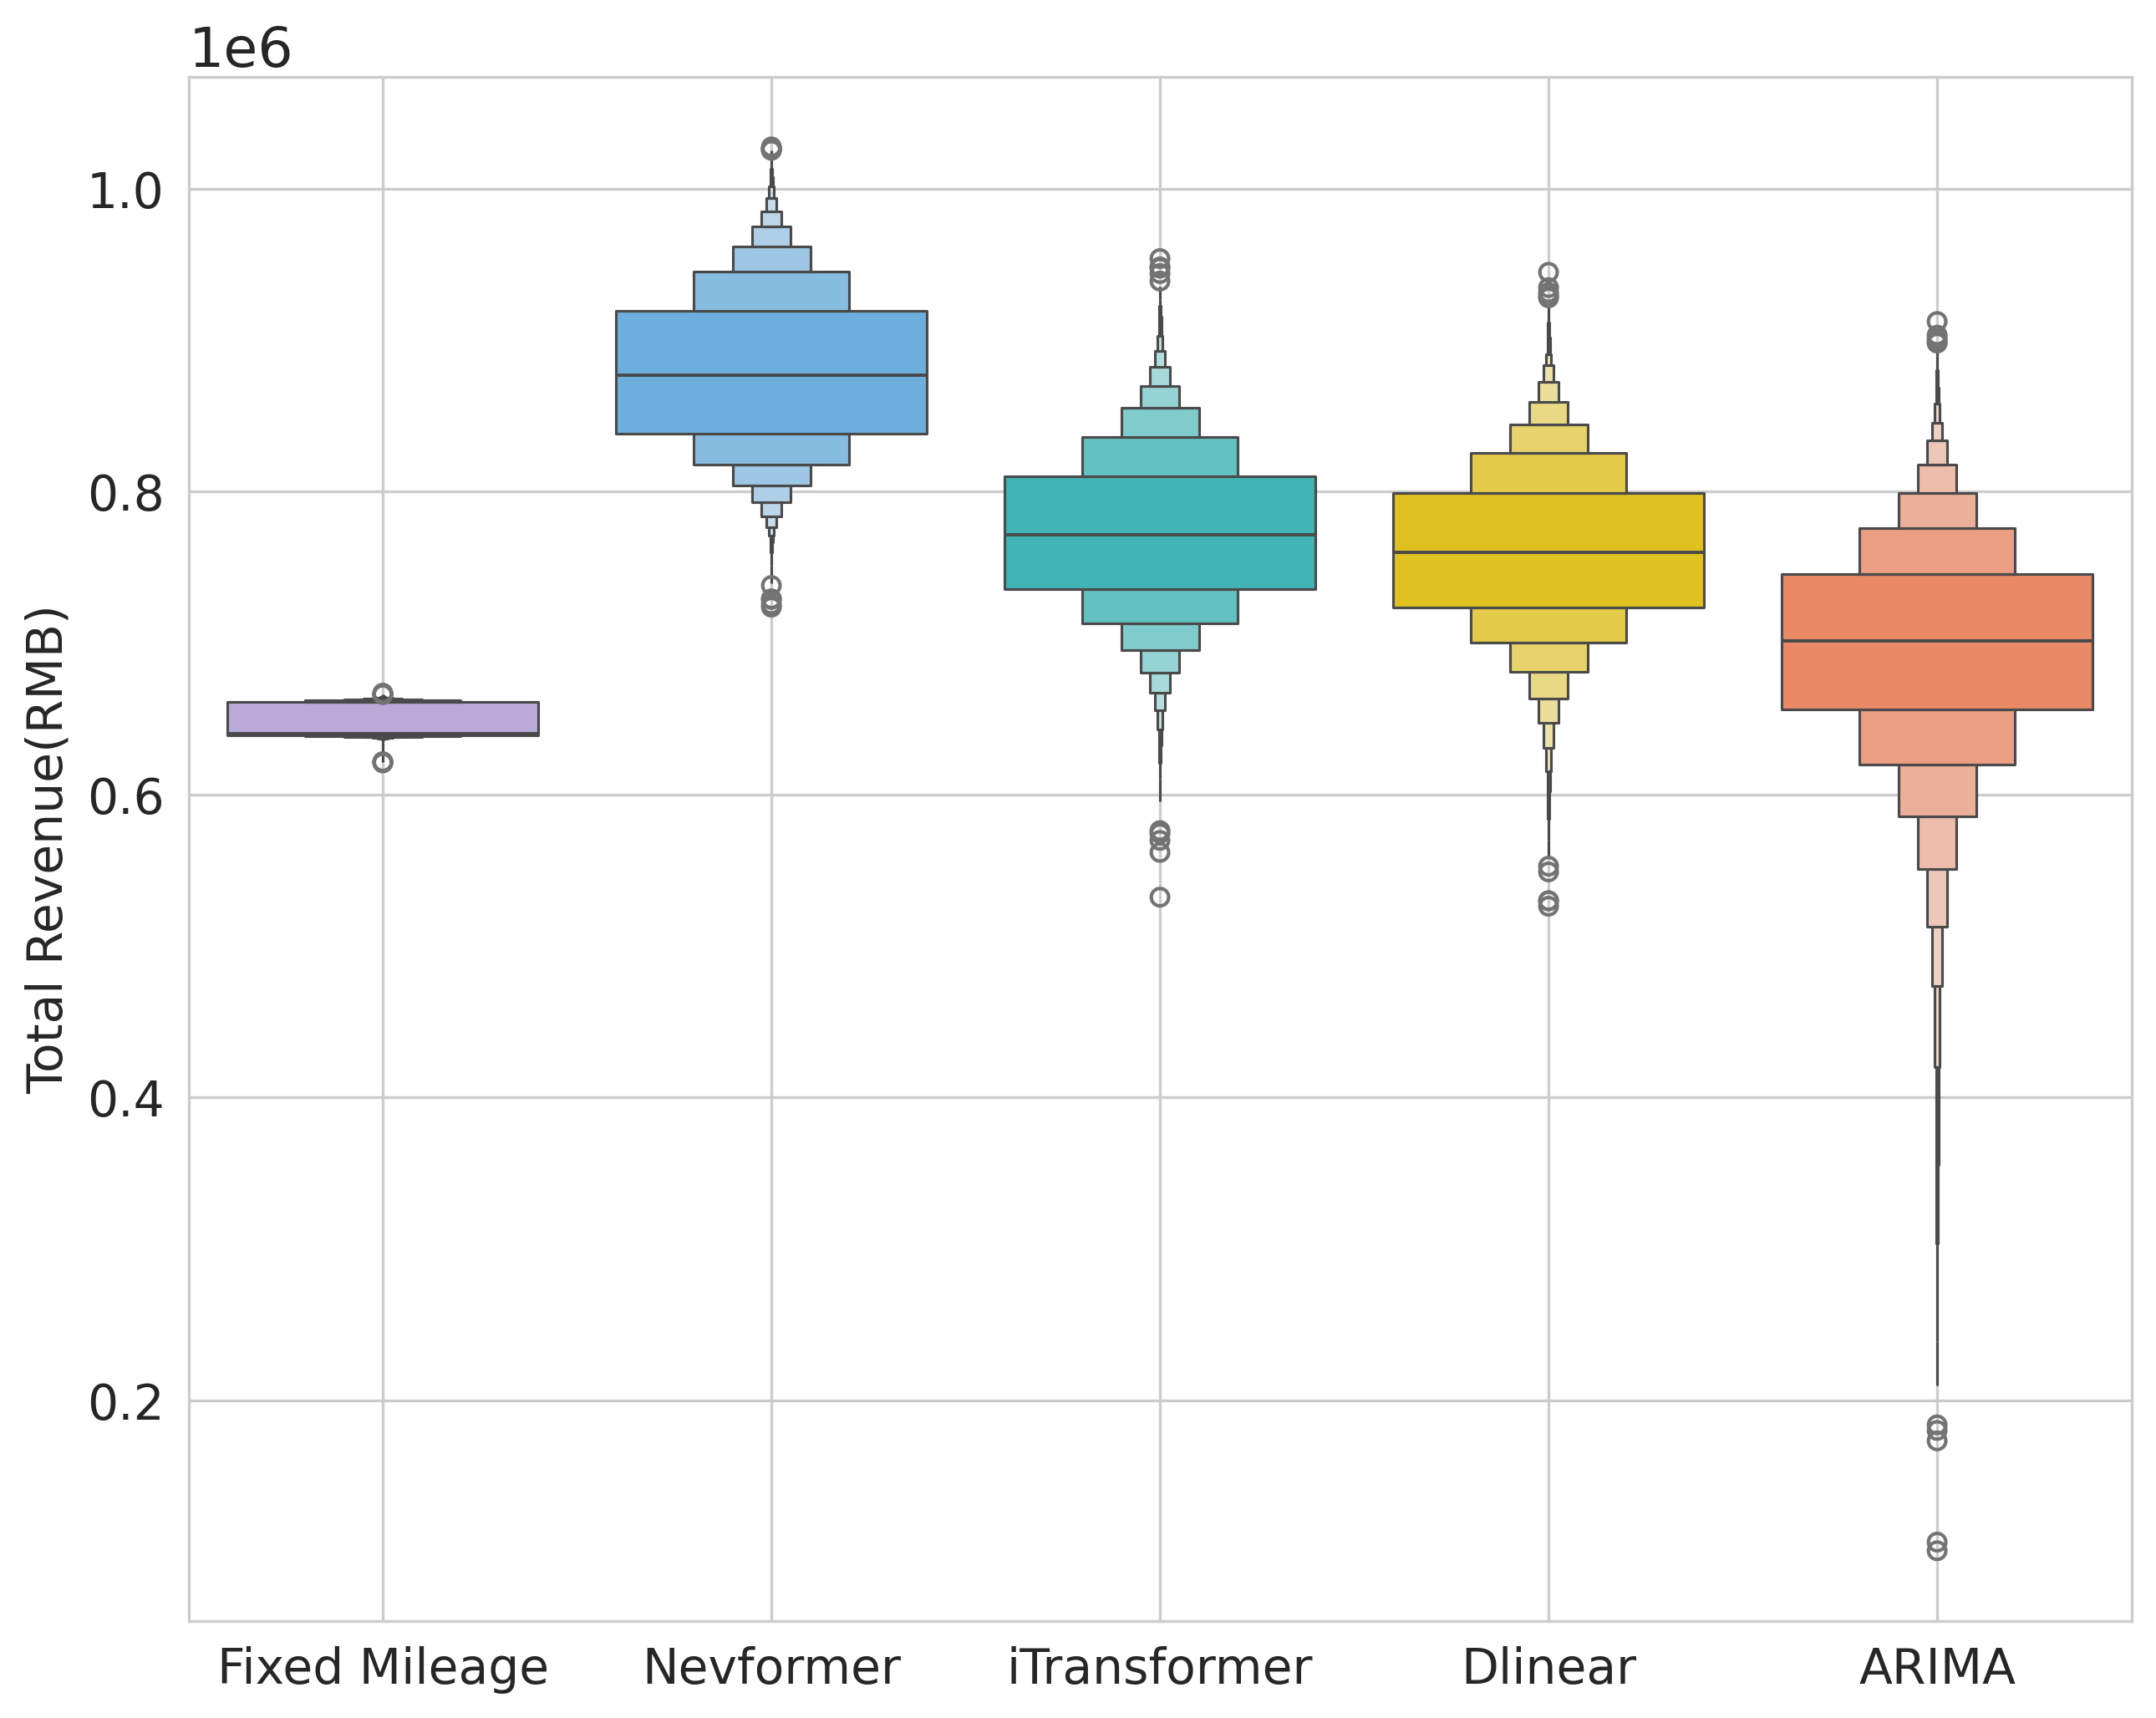

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

recyle_mean = {}
data = {'Fixed Mileage': fixed_profits}
data.update({f'{e}': profits for e, profits in flexible_profits.items()})
df = pd.DataFrame(data)

light_colors = [
    '#b6a2de',
    '#5ab1ef',
    '#2ec7c9',  
    '#FFD700',  
    '#FF7F50',
     
]

plt.figure(figsize=(10, 4))
plt.rcParams['figure.dpi'] = 300
sns.set_style("whitegrid")
box_plot = sns.boxenplot(data=df, palette=light_colors)  # 使用箱式图并设置颜色


# plt.title("Revenue Distribution per Vehicle across Strategies", fontsize=16)
plt.ylabel("Total Revenue(RMB)", fontsize=14)
plt.grid(True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for i, column in enumerate(df.columns):
    mean = df[column].mean()
    recyle_mean[column] = mean
plt.show()

# 定义每年退役车数量

In [7]:
## Define the number of retired vehicles each year
retired = {2021: 10.5, 2022: 20.7, 2023: 32.1, 2024: 45.6, 2025: 55.6, 2026: 71.0, 2027: 116.3, 2028: 183.2, 2029: 273.2, 2030: 380.3}

# Multiply the number of retired vehicles each year by a factor
retierd = {year: int(retired[year] * 20000) for year in retired.keys()}

## Get the total profit of retired vehicles each year as a DataFrame
retired_profits = pd.DataFrame(
    {year: [recyle_mean[key] * retired[year] for key in recyle_mean.keys()] for year in retired.keys()},
    index=list(recyle_mean.keys())
)

for year, retired_vehicles in retierd.items():
    for strategy, mean in recyle_mean.items():
        profit = retired_vehicles * mean
        retired_profits.loc[strategy, year] = profit

## Subtract the profits of the fixed mileage strategy from the other strategies
retired_profits = retired_profits.sub(retired_profits.loc['Fixed Mileage'], axis=1)
retired_profits = retired_profits.drop('Fixed Mileage')


In [8]:
retired_profits

,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
Nevformer,4.888852e+10,9.638023e+10,1.494592e+11,2.123159e+11,2.588764e+11,3.305795e+11,5.414986e+11,8.529883e+11,1.272033e+12,1.770696e+12
iTransformer,2.649331e+10,5.222968e+10,8.099385e+10,1.150567e+11,1.402884e+11,1.791453e+11,2.934450e+11,4.622453e+11,6.893308e+11,9.595626e+11
Dlinear,2.399131e+10,4.729716e+10,7.334486e+10,1.041908e+11,1.270397e+11,1.622270e+11,2.657323e+11,4.185913e+11,6.242311e+11,8.689424e+11
ARIMA,1.055700e+10,2.081237e+10,3.227426e+10,4.584755e+10,5.590184e+10,7.138544e+10,1.169314e+11,1.841945e+11,2.746831e+11,3.823645e+11


<Figure size 2700x1800 with 0 Axes>

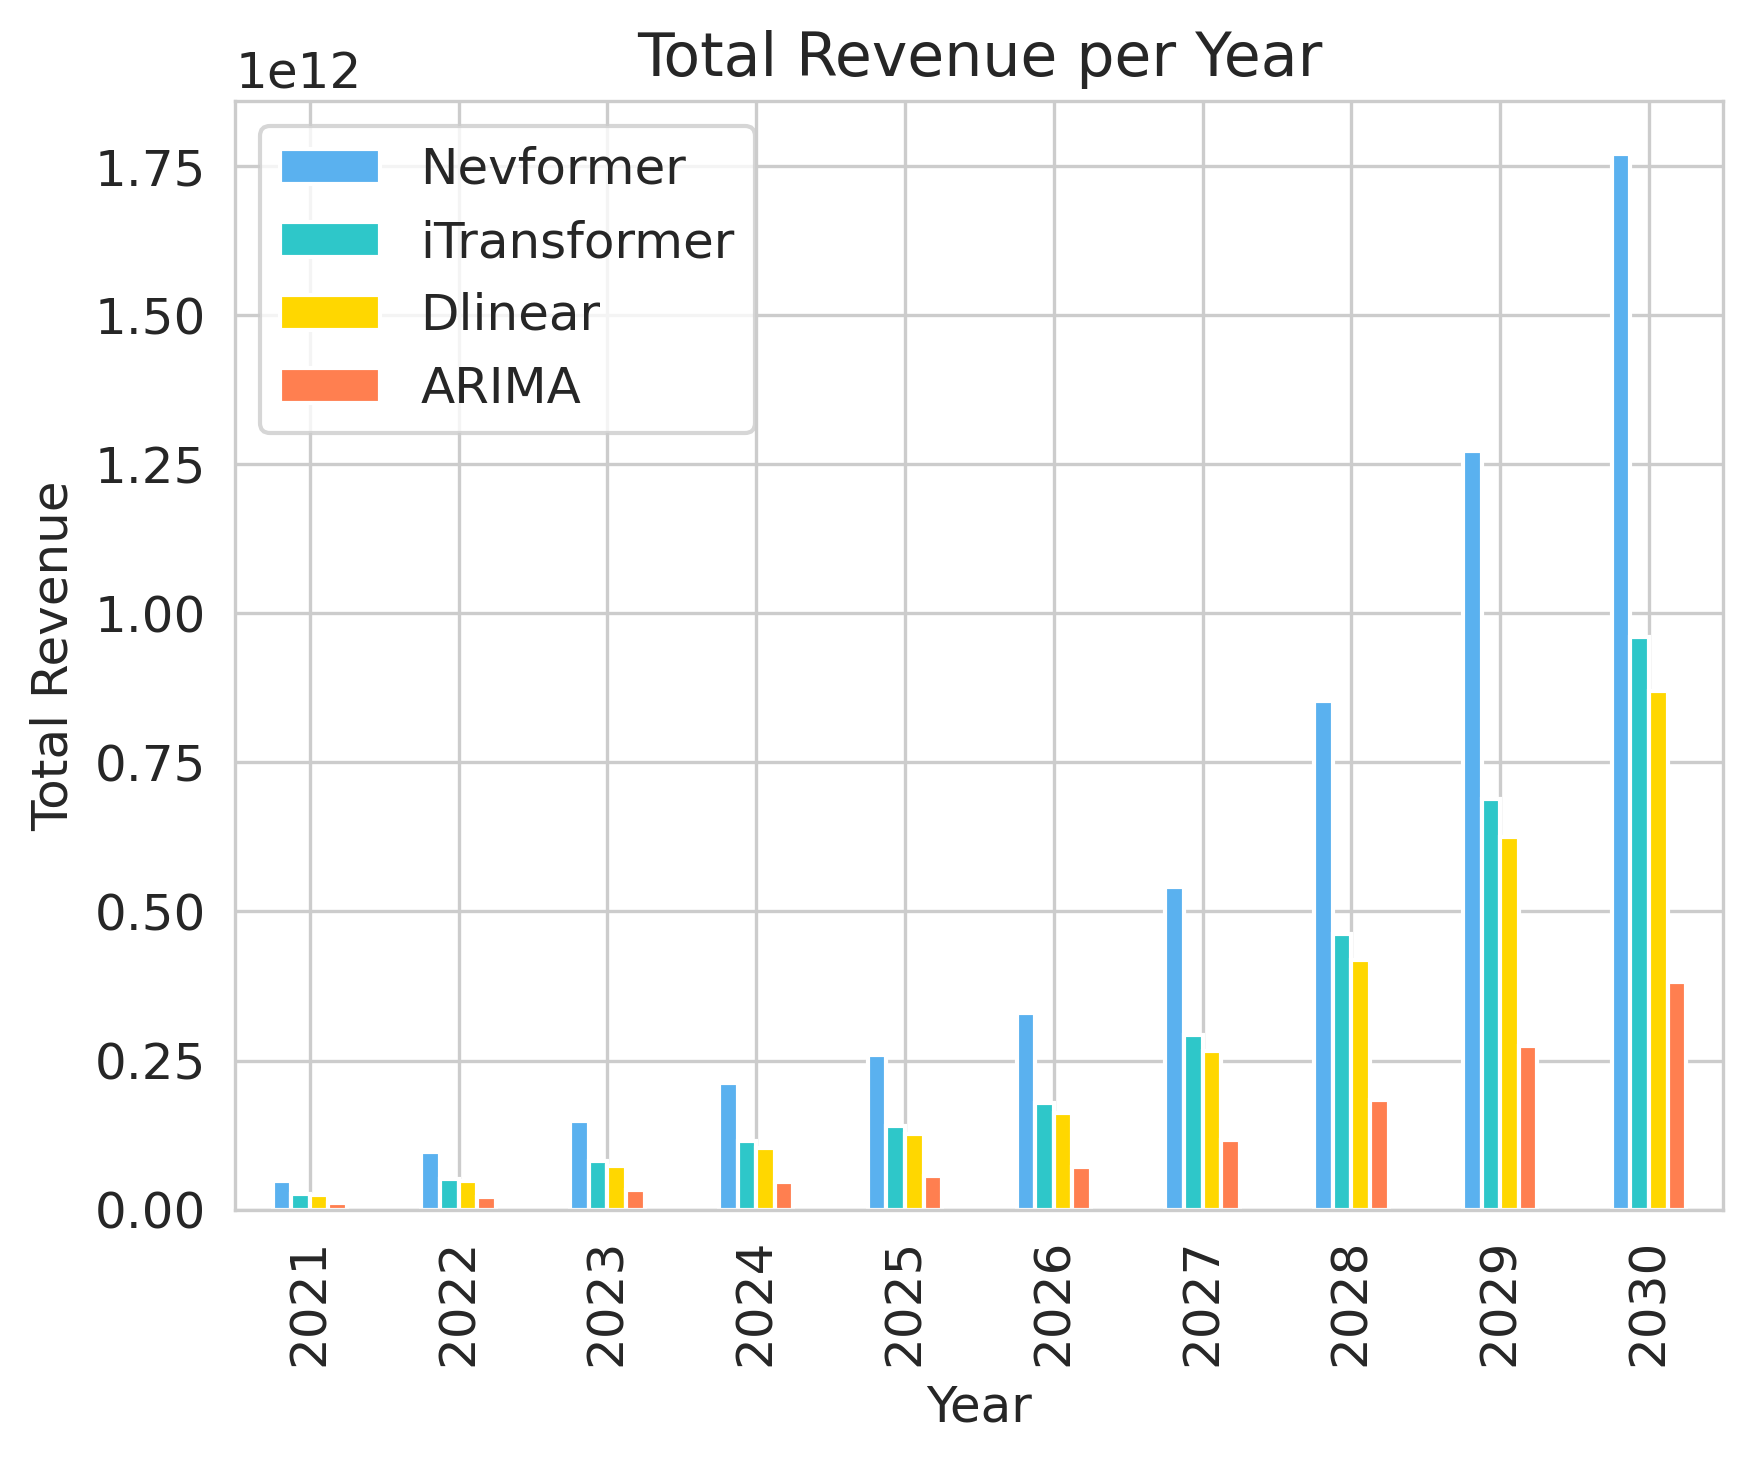

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置全局字体大小
plt.rcParams.update({'font.size': 12})

# 设置风格为白色网格
sns.set_style("whitegrid")

# 创建一个新的图形
plt.figure(figsize=(9, 6))

# 定义颜色
light_colors = [
    '#5ab1ef',
    '#2ec7c9',  
    '#FFD700',  
    '#FF7F50'  
]

# 绘制条形图
retired_profits.T.plot(kind='bar', color=light_colors)

# 设置标题和标签
plt.title("Total Revenue per Year")
plt.xlabel("Year")
plt.ylabel("Total Revenue")

# 显示图形
plt.show()

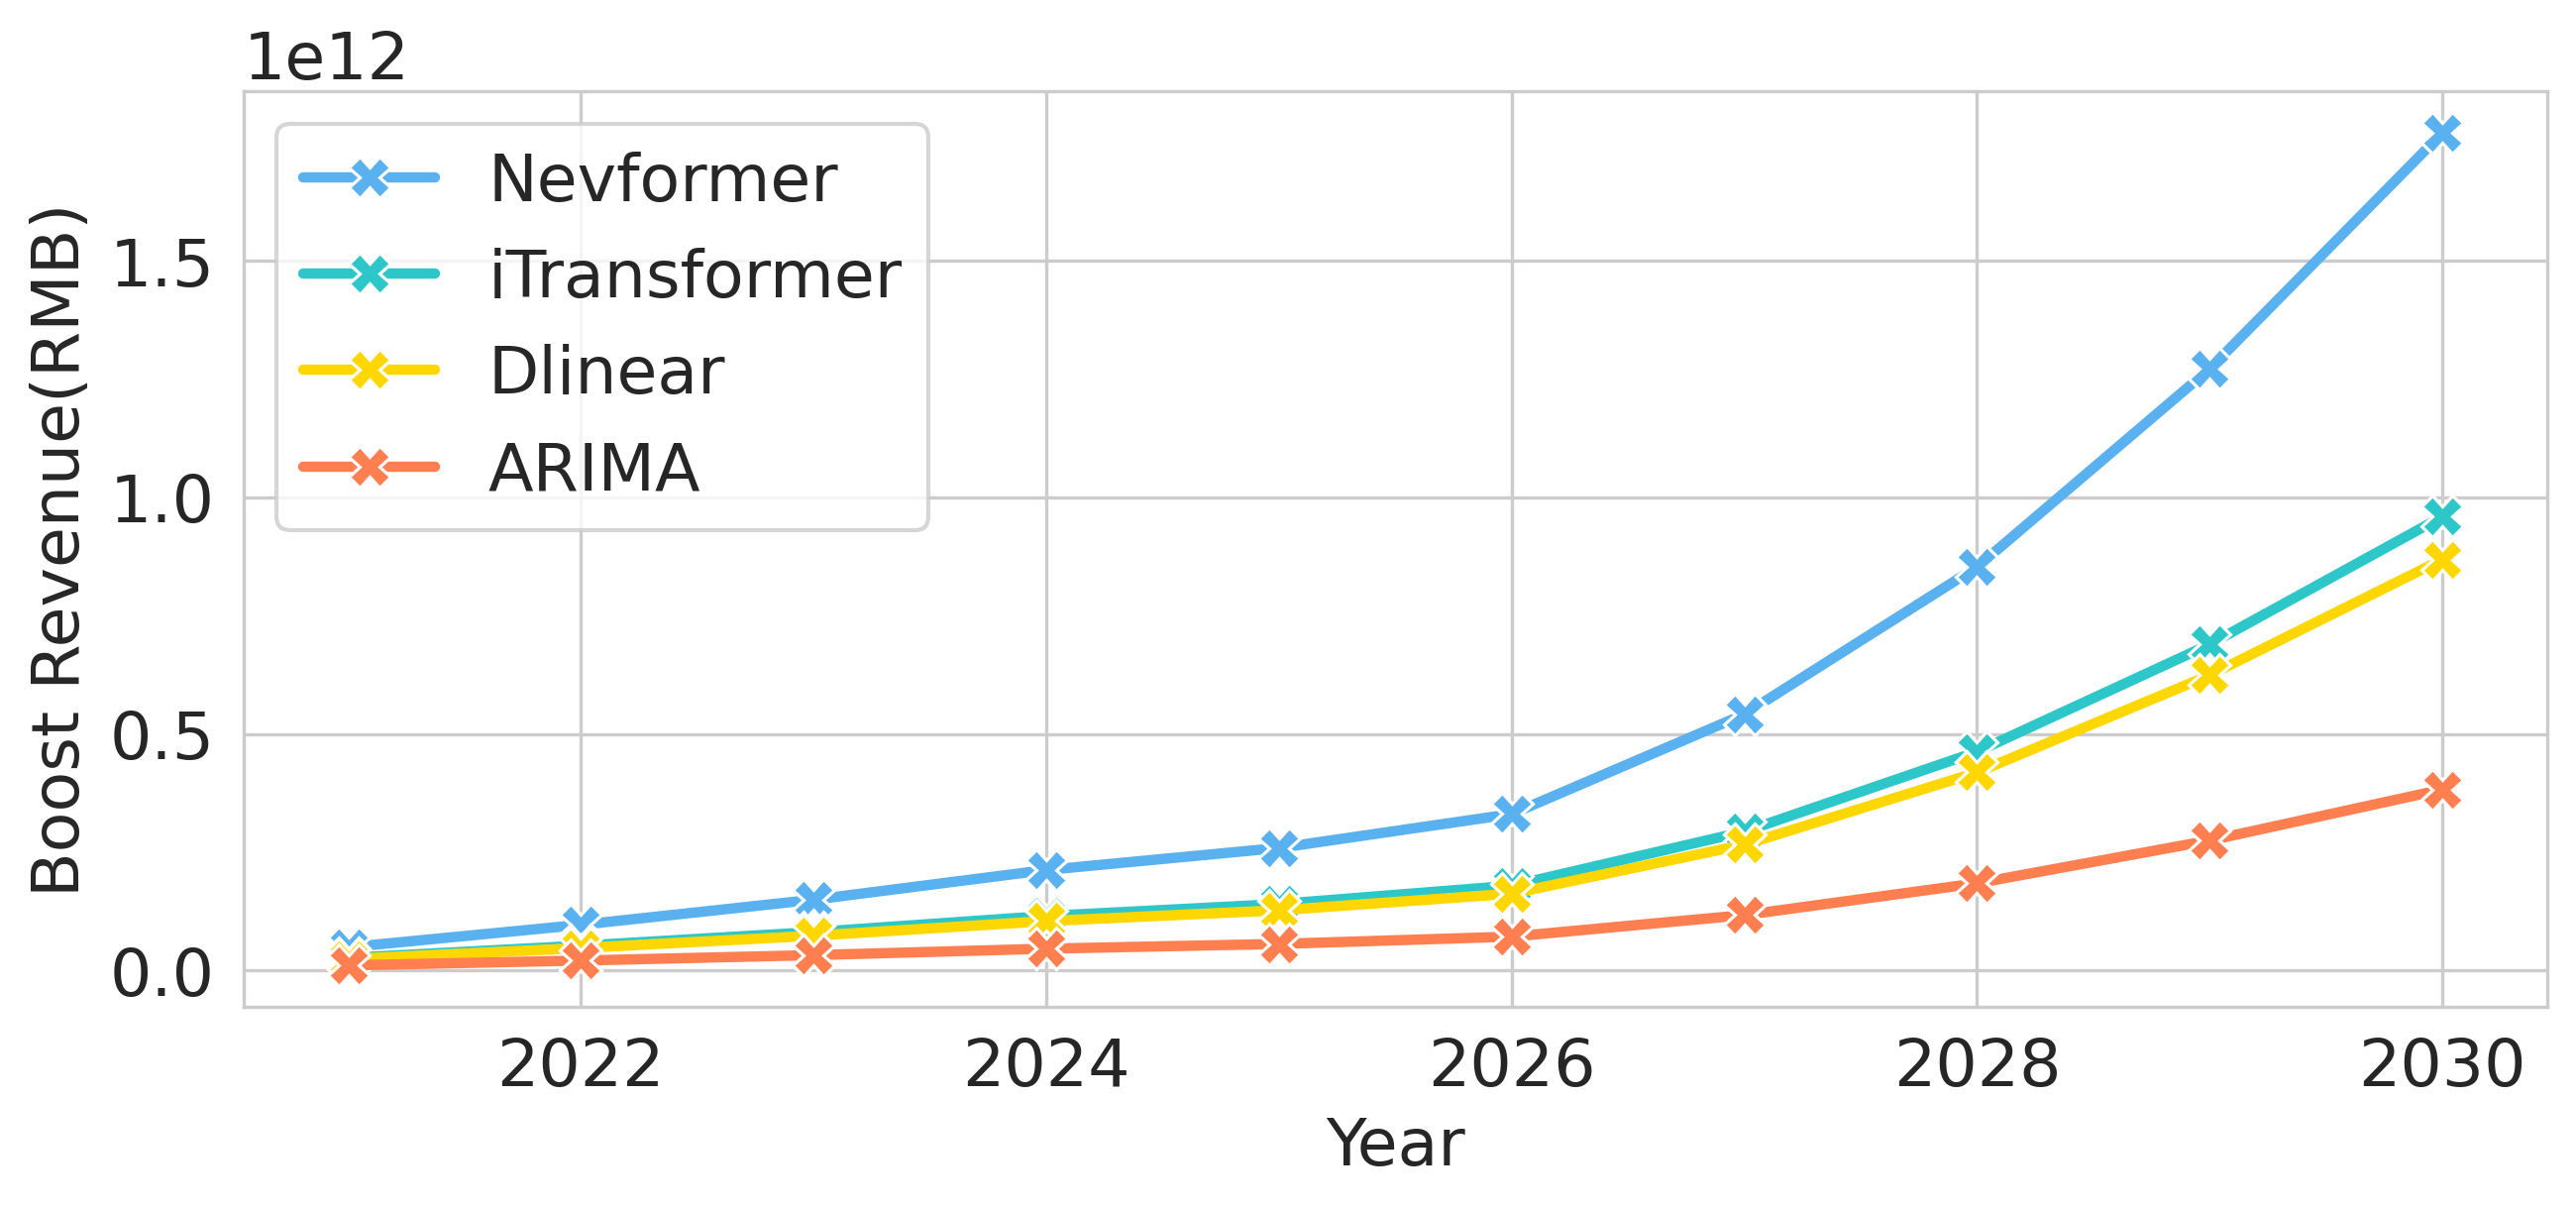

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置全局字体大小
plt.rcParams.update({'font.size': 16})

# 设置风格为白色网格

plt.figure(figsize=(10, 4))
plt.rcParams['figure.dpi'] = 300
sns.set_style("whitegrid")
# 定义马卡龙颜色列表
light_colors = [
    '#5ab1ef',
    '#2ec7c9',  
    '#FFD700',  
    '#FF7F50'  
]
# 绘制四个曲线
for i, method in enumerate(retired_profits.index):
    sns.lineplot(x=retired_profits.columns, y=retired_profits.loc[method], label=method, linewidth=2.5, marker='X', markersize=10, color=light_colors[i])

# 设置标题和标签
# plt.title("Total Boost Revenue per Year")
plt.xlabel("Year")
plt.ylabel("Boost Revenue(RMB)")

# 设置图例位置
plt.legend(loc='upper left')

# 显示图形
plt.show()